### Importing Libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate

### Dataset preparation

In [2]:
df = pd.read_csv('daily_clean_full.csv')
df.head()
df = df.iloc[:,0:9]
df['datetime'] = df['datetime'].apply(pd.to_datetime)
df.set_index('datetime',inplace=True)

### Insights of dataset

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2918 entries, 2011-01-01 to 2018-12-27
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp_avr    2918 non-null   float64
 1   temp_max    2918 non-null   float64
 2   temp_min    2918 non-null   float64
 3   pres        2918 non-null   float64
 4   u           2918 non-null   float64
 5   v           2918 non-null   float64
 6   prec        2918 non-null   float64
 7   Budateteny  2918 non-null   float64
dtypes: float64(8)
memory usage: 205.2 KB


In [80]:
df.describe(include = "all")

,temp_avr,temp_max,temp_min,pres,u,v,prec,Budateteny
count,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000
mean,12.101243,16.445134,7.855757,1017.227027,0.271481,-0.419457,1.393180,26.104695
std,8.923907,10.188715,7.827295,7.549074,1.624770,1.294674,4.224996,15.450426
min,-12.200000,-9.200000,-16.400000,981.830521,-3.968283,-5.282087,0.000000,2.000000
25%,5.000000,8.100000,1.600000,1012.471061,-0.849982,-1.275954,0.000000,15.000000
50%,12.629167,16.900000,8.100000,1016.719324,0.072961,-0.357204,0.000000,22.000000
75%,19.553125,24.800000,14.400000,1021.437686,1.236929,0.468496,0.400000,34.000000
max,30.850000,38.300000,26.200000,1041.392298,6.842006,4.862748,68.000000,131.000000


<AxesSubplot:xlabel='datetime', ylabel='Budateteny'>

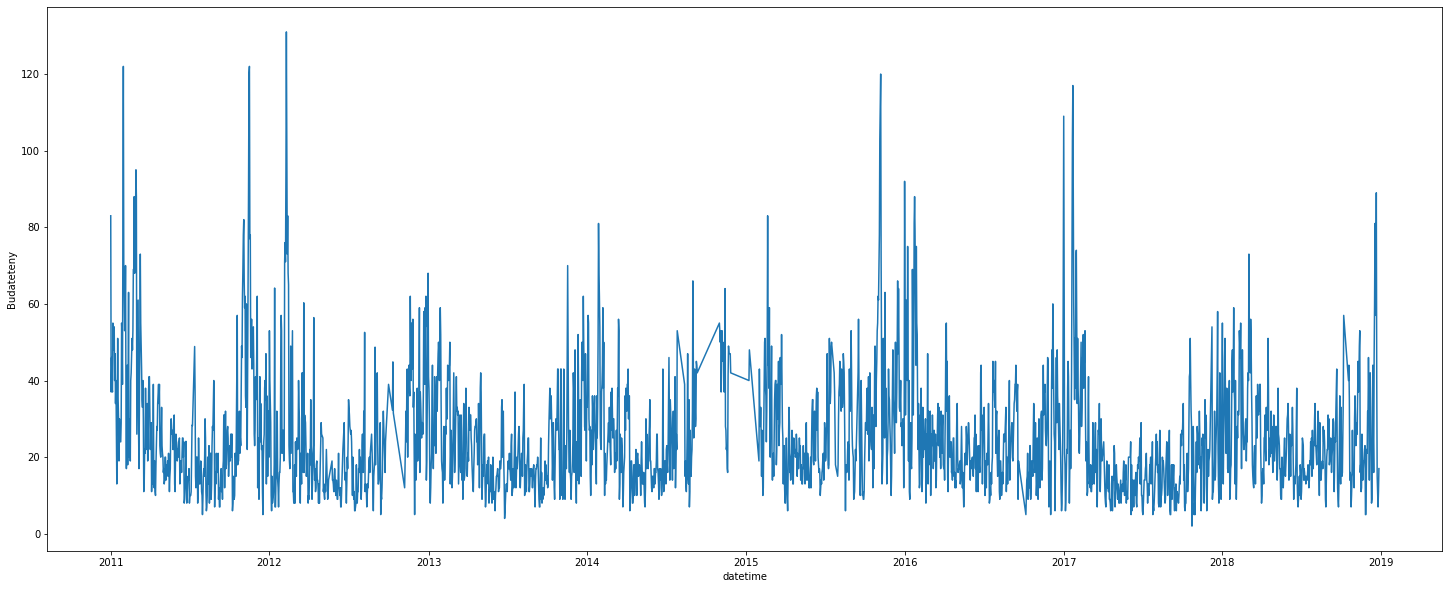

In [81]:
dims = (25, 10)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=df, x= df.index, y="Budateteny", ax=ax)

### Data preprocessing

In [82]:
# Identify and handle missing values
df.isnull().sum().sort_values(ascending=False)

Budateteny    0
prec          0
v             0
u             0
pres          0
temp_min      0
temp_max      0
temp_avr      0
dtype: int64

In [4]:
#checking the Duplicated records
df.duplicated().sum()
#df.drop_duplicates(inplace=True)

0

In [5]:
dataset = df
values = dataset.values

In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
#divide the data into train and test data
train_size = int(len(scaled) * 0.80)
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]

In [8]:
# frame as supervised learning
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [9]:
X_train, y_train = split_series(train,30, 1)
X_test, y_test = split_series(test,30,1)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2304, 30, 8)
(2304, 1, 8)
(554, 30, 8)
(554, 1, 8)


### Model development

In [12]:
n_past = 30
n_features = 8
n_future = 1

In [13]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 8)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 43600       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 1, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [14]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test),batch_size=64,verbose=0,callbacks=[reduce_lr])

### Making Predictions

In [15]:
train_pred=model_e1d1.predict(X_train)
test_pred=model_e1d1.predict(X_test)

In [20]:
def arrange(data):
    a,b,r = data.shape
    out_arr = np.column_stack((np.repeat(np.arange(a),b),data.reshape(a*b,-1)))
    return(pd.DataFrame(out_arr).drop(columns = 0))

In [21]:
train_pred_ar = arrange(train_pred)
test_pred_ar = arrange(test_pred)

In [22]:
train_pred_ar

,1,2,3,4,5,6,7,8
0,0.196995,0.197567,0.275813,0.701746,0.276685,0.538367,0.017231,0.497211
1,0.180118,0.166423,0.254365,0.727182,0.306680,0.532385,0.009865,0.485088
2,0.170661,0.149959,0.238966,0.756969,0.344724,0.536966,0.003553,0.468011
3,0.164642,0.138238,0.221472,0.783600,0.404764,0.512124,-0.003331,0.431483
4,0.173450,0.150928,0.226393,0.784770,0.398853,0.528505,-0.000233,0.430833
...,...,...,...,...,...,...,...,...
2299,0.713312,0.702484,0.679401,0.690673,0.317546,0.486723,0.007137,0.138206
2300,0.728873,0.713920,0.690326,0.638878,0.347717,0.501457,0.008031,0.132573
2301,0.752553,0.732523,0.715010,0.565043,0.353455,0.515351,0.016668,0.133388
2302,0.711605,0.680886,0.676516,0.572669,0.445404,0.441552,0.008415,0.092665


In [23]:
test_pred_ar

,1,2,3,4,5,6,7,8
0,0.853831,0.842357,0.799729,0.531810,0.436230,0.467681,0.023218,0.101747
1,0.870789,0.858857,0.817701,0.521215,0.445830,0.462590,0.025547,0.104761
2,0.865642,0.847032,0.816447,0.509660,0.491676,0.439028,0.024932,0.087201
3,0.862523,0.849097,0.814805,0.529704,0.504462,0.433937,0.021138,0.090000
4,0.854298,0.840583,0.822435,0.508699,0.478250,0.469991,0.030112,0.115549
...,...,...,...,...,...,...,...,...
549,0.288060,0.249418,0.325550,0.610831,0.379979,0.514614,0.025893,0.362531
550,0.345432,0.304086,0.359276,0.612185,0.495748,0.484012,0.018879,0.249371
551,0.345346,0.299536,0.360585,0.600822,0.540293,0.431041,0.023257,0.184116
552,0.311895,0.282350,0.326321,0.716472,0.545853,0.407797,0.002864,0.165207


In [26]:
predicted_train = pd.DataFrame(scaler.inverse_transform(train_pred_ar))

In [27]:
predicted_test = pd.DataFrame(scaler.inverse_transform(test_pred_ar))

In [30]:
predicted_train[7].values

array([66.14017791, 64.57630083, 62.37347177, ..., 19.20703249,
       13.95373717, 11.31424984])

### Evaluating the model

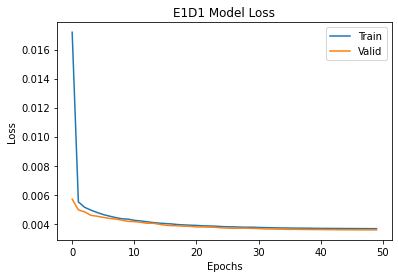

In [31]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [78]:
def rmsle(train_pred, y_test):
    error = np.square(np.log10(train_pred+1) - np.log10(y_test +1)).mean() ** 0.5
    ACC = 1-error
    return(ACC*100)
print("Training accuracy of the model : %.f%% " % rmsle(train_pred, y_train))
print("Testing accuracy of the model : %.f%% " %  rmsle(test_pred, y_test))

Training accuracy of the model : 97% 
Testing accuracy of the model : 97% 


In [37]:
pd.DataFrame(scaler.inverse_transform(arrange(X_test)))

,0,1,2,3,4,5,6,7
0,18.408696,25.3,15.0,1016.386138,-0.632728,-0.024916,14.0,14.0
1,17.845833,22.1,14.3,1015.172228,2.239503,-1.560629,0.8,18.0
2,15.625000,19.6,10.7,1016.660995,1.683468,-2.271716,0.0,8.0
3,18.012500,22.4,12.8,1017.333162,1.052798,-1.823396,0.0,11.0
4,18.908333,24.2,13.1,1019.855177,-0.821437,-1.405909,0.0,10.0
...,...,...,...,...,...,...,...,...
16615,3.183333,8.3,-1.3,1015.405543,1.071415,0.931442,3.0,40.0
16616,7.483333,10.3,5.7,1019.844067,3.914364,-0.015945,0.0,15.0
16617,4.479167,7.3,1.4,1014.172311,2.560526,-1.852389,7.0,11.0
16618,2.175000,3.8,0.7,1027.126803,3.471999,-3.291600,0.0,7.0


In [49]:
pd.DataFrame(scaler.inverse_transform(arrange(X_test)))

,0,1,2,3,4,5,6,7
0,18.408696,25.3,15.0,1016.386138,-0.632728,-0.024916,14.0,14.0
1,17.845833,22.1,14.3,1015.172228,2.239503,-1.560629,0.8,18.0
2,15.625000,19.6,10.7,1016.660995,1.683468,-2.271716,0.0,8.0
3,18.012500,22.4,12.8,1017.333162,1.052798,-1.823396,0.0,11.0
4,18.908333,24.2,13.1,1019.855177,-0.821437,-1.405909,0.0,10.0
...,...,...,...,...,...,...,...,...
16615,3.183333,8.3,-1.3,1015.405543,1.071415,0.931442,3.0,40.0
16616,7.483333,10.3,5.7,1019.844067,3.914364,-0.015945,0.0,15.0
16617,4.479167,7.3,1.4,1014.172311,2.560526,-1.852389,7.0,11.0
16618,2.175000,3.8,0.7,1027.126803,3.471999,-3.291600,0.0,7.0


In [46]:
train.shape

(2334, 8)

In [45]:
test.shape

(584, 8)

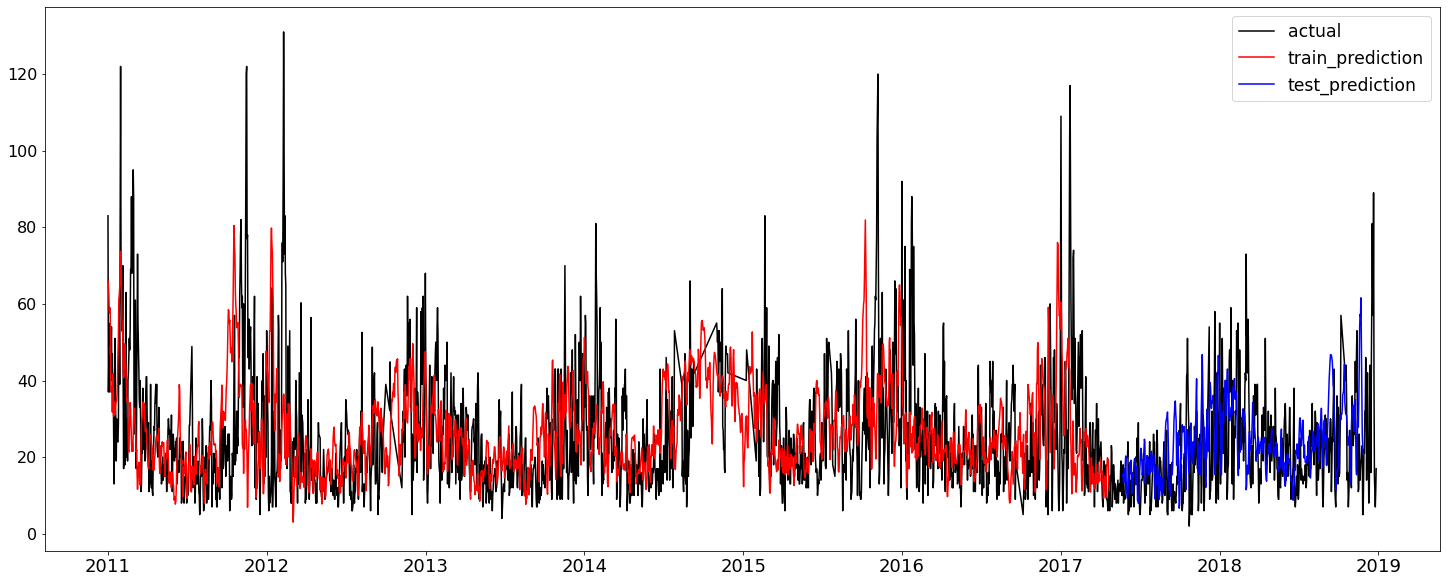

In [56]:
#We will use it further to show the graph of multi step prediction
df_train = df.iloc[0:2304]
df_test = df.iloc[2334:2888]
#plotting the graph to show multi step prediction
plt.figure(figsize=(25, 10))
plt.plot(df.index, df["Budateteny"],'k', label="actual" )
plt.plot(df_train.index, predicted_train[7].values,'r',label="train_prediction")
plt.plot(df_test.index, predicted_test[7].values,color = 'b',label="test_prediction")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

### Predicting next day pollution(PM) based on last 30 days data as input in budateteny city

In [57]:
pd.DataFrame(scaled)

,0,1,2,3,4,5,6,7
0,0.209391,0.153684,0.276995,0.646894,0.456240,0.623293,0.000000,0.627907
1,0.255226,0.250526,0.274648,0.605857,0.505872,0.519141,0.000000,0.271318
2,0.178571,0.153684,0.204225,0.680843,0.327605,0.475133,0.000000,0.341085
3,0.179733,0.120000,0.255869,0.738482,0.355156,0.626395,0.000000,0.279070
4,0.171893,0.103158,0.255869,0.734844,0.196750,0.664195,0.000000,0.271318
...,...,...,...,...,...,...,...,...
2913,0.457220,0.410526,0.518779,0.638220,0.729180,0.519096,0.000000,0.100775
2914,0.387437,0.347368,0.417840,0.542996,0.603944,0.338073,0.102941,0.069767
2915,0.333914,0.273684,0.401408,0.760492,0.688259,0.196207,0.000000,0.038760
2916,0.379791,0.311579,0.460094,0.754523,0.780637,0.327924,0.000000,0.069767


In [59]:
val = scaled[-31:]

In [62]:
val = split_series(val,30, 1)

In [63]:
val_pred=model_e1d1.predict(val)

In [64]:
val_pred

array([[[ 0.3264316 ,  0.30853677,  0.3318937 ,  0.7557725 ,
          0.57276374,  0.41798192, -0.00826358,  0.145214  ]]],
      dtype=float32)

In [65]:
val_pred_ar = arrange(val_pred)

In [66]:
val_pred_ar

,1,2,3,4,5,6,7,8
0,0.326432,0.308537,0.331894,0.755772,0.572764,0.417982,-0.008264,0.145214


In [67]:
predicted_val = pd.DataFrame(scaler.inverse_transform(val_pred_ar))

In [68]:
predicted_val

,0,1,2,3,4,5,6,7
0,1.85288,5.455496,-2.261328,1026.845673,2.223458,-1.041729,-0.561923,20.732607


In [70]:
df.columns.tolist()

['temp_avr', 'temp_max', 'temp_min', 'pres', 'u', 'v', 'prec', 'Budateteny']

In [74]:
predicted_val.columns = df.columns.tolist()

In [76]:
predicted_val

,temp_avr,temp_max,temp_min,pres,u,v,prec,Budateteny
0,1.85288,5.455496,-2.261328,1026.845673,2.223458,-1.041729,-0.561923,20.732607
